In [153]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import lightgbm_with_simple_features as lgbmsf
import json
import seaborn as sns
import re
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, ParameterGrid

with open('config.json', 'r') as f:
    config = json.load(f)
    
NUM_ROWS = config["NUM_ROWS"]
PATH = config["PATH"]

On explore dans ce notebook les prédictions obtenues avec l'algorithme LightGBM utilisé dans le kernel kaggle. On compare ces prédictions avec des méthodes de classification naïve (DummyClassifier).

## I. Création de la table finale

In [2]:
# liste des fichiers
os.listdir(PATH)

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'home_credit.png',
 'HomeCredit_columns_description.csv',
 'imputer_selection.py',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'Projet+Mise+en+prod+-+home-credit-default-risk.zip',
 'sample_submission.csv']

Il y a 9 fichiers, et on sait par la description donnée sur kaggle qu'ils sont liés entre eux via le schéma suivant

![home_credit](./data/home_credit.png)

## I.1 Jointures des tables

On réalise la jointure de toutes les tables en utilisant les clés correspondantes à l'exception de la table application_test.csv qui correspond aux données utilisées pour la compétition kaggle.\
Les jointures sont réalisées grâce au kernel kaggle dont on a modifié légèrement le code pour utiliser cette fonctionnalité indépendamment.

In [154]:
# Jointures
data = lgbmsf.join_df(num_rows=NUM_ROWS)

Train samples: 15000
Bureau df shape: (2984, 108)
Process bureau and bureau_balance - done in 3s
Previous applications df shape: (14432, 245)
Process previous_applications - done in 3s
Pos-cash balance df shape: (14088, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (12780, 26)
Process installments payments - done in 2s
Credit card balance df shape: (13667, 131)
Process credit card balance - done in 3s


### Inspection de la table créée

In [59]:
len(data.columns)

769

In [155]:
nna = data.notna().sum()/data.shape[0]

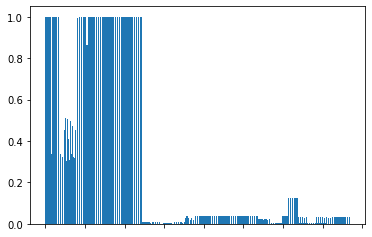

In [29]:
fig, ax = plt.subplots()
ax.bar(x=np.arange(len(data.columns)), height=nna)
ax.set_xticklabels('')
plt.show()

## I.2 Nettoyage et imputations

Retirons les colonnes remplies à moins de 70%

In [156]:
nfilled_cols = nna[nna<0.7].index
nfilled_cols

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=570)

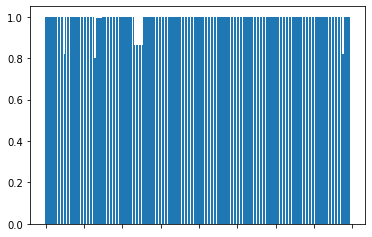

In [7]:
filled_data = data.drop(columns=nfilled_cols)
nna = filled_data.notna().sum()/filled_data.shape[0]
fig, ax = plt.subplots()
ax.bar(x=np.arange(len(filled_data.columns)), height=nna)
ax.set_xticklabels('')
plt.show()

### Imputations

In [157]:
filled_data.fillna(filled_data.mean(), inplace=True)

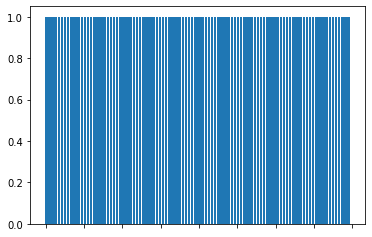

In [9]:
nna = filled_data.notna().sum()/filled_data.shape[0]
fig, ax = plt.subplots()
ax.bar(x=np.arange(len(filled_data.columns)), height=nna)
ax.set_xticklabels('')
plt.show()

## I.3 Prédictions

In [158]:
feats = filled_data.drop(columns=['SK_ID_CURR', 'TARGET']).columns
X = filled_data.drop(columns=['SK_ID_CURR', 'TARGET']).to_numpy()
y = filled_data.TARGET.to_numpy()

# Séparation en jeux d'entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### I.3.1 Baselines

**1. La classe majoritaire est prédite systématiquement**

In [13]:
dummyclf = DummyClassifier(strategy='most_frequent',)
dummyclf.fit(X_train, y_train)
y_pred = dummyclf.predict(X_test)
print("AUROC Score : {:.2f}".format(roc_auc_score(y_test, y_pred)))

AUROC Score : 0.50


**2. Les étiquettes sont prédites aléatoirement parmi {0, 1}**

In [14]:
dummyclf = DummyClassifier(strategy='uniform')
dummyclf.fit(X_train, y_train)
y_pred = dummyclf.predict(X_test)
print("AUROC Score : {:.2f}".format(roc_auc_score(y_test, y_pred)))

AUROC Score : 0.49


### I.3.2 Prédictions avec LightGBM

In [31]:
# Séparation en jeu d'entraînement/validation pour la recherche sur grille
#X_val_train, X_val_val, y_val_train, y_val_val = \
#train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

# Nested cross-validation pour la validation du (des) hyperparamètre(s) par GridSearch
inner_cv = StratifiedKFold(n_splits=5).split(X_train, y_train)

# Hyperparamètre(s) à optimiser
param_grid = {"n_estimators" : [100, 1000, 10000],
              "max_depth" : [-1, 5, 10], 
              "colsample_bytree" : [0.5, 0.8, 1],
              "num_leaves" : [10, 30, 50],
             }    

#for params in ParameterGrid(param_grid):
model = LGBMClassifier(#early_stopping_round=200,
                               objective='binary',
                               metric='AUC',
                               is_unbalance=True,
                               silent=False,
                               verbosity=-1,
                              )

# Régression avec sélection d'(des)hyperparamètre(s) par validation croisée
regr = GridSearchCV(
estimator=model,            # modèle
param_grid=param_grid,     # hyperparamètres à tester
cv=inner_cv,    # nombre de folds de validation croisée
scoring='roc_auc',   # score à optimiser
return_train_score=True,
)

# Optimisation de l'estimateur sur le jeu d'entraînement
regr.fit(X=X_train, y=y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("\nMeilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(regr.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'colsample_bytree': 0.5, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 10}


In [36]:
bestmodel = LGBMClassifier(early_stopping_round=200,
                               objective='binary',
                               metric='AUC',
                               is_unbalance=True,
                               silent=False,
                               verbosity=-1,
                           **regr.best_params_)

bestmodel.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=-1)
y_pred = bestmodel.predict(X_test)

# Performance sur le jeu d'entraînement
print("\nPerformance sur le jeu d'entraînement' : {:.3f}".format(regr.best_score_))

# Performance en généralisation du meilleur modèle sur le jeu de test
y_pred = regr.predict(X_test)
print("Performance en généralisation sur le jeu de test : {:.3f}".format(roc_auc_score(y_test, y_pred)))

In [37]:
with open('fitted_lgbm.pickle', 'wb') as f:
    pickle.dump(bestmodel, f)

In [165]:
with open('./FastAPI/fitted_lgbm.pickle', 'rb') as f:
    bestmodel = pickle.load(f)

**1. Prédiction de la classe la plus fréquente**

In [ ]:
dummyclf = DummyClassifier(strategy='most_frequent', random_state=0)
dummyclf.fit(X_train, y_train)

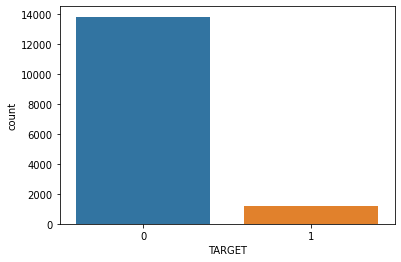

In [37]:
fig, ax = plt.subplots()
sns.countplot(data=filled_data, x='TARGET')
plt.show()

In [38]:
y_test = np.zeros(filled_data.shape[0])
y_test

array([0., 0., 0., ..., 0., 0., 0.])

In [161]:
bestmodel.predict([X_test[0]])

array([0])

In [162]:
X_test.shape

(4500, 197)

# FastAPI

In [168]:
import requests 

new_measurement = {
    'client_id': 0,
    'client_name': "Smith",
}

response = requests.post('http://127.0.0.1:8000/predict', json=new_measurement)
print(response.content)

b'Internal Server Error'
